In [1]:
%%capture
!sudo apt-get install -y software-properties-common
!sudo add-apt-repository -y ppa:fenics-packages/fenics
!sudo apt-get -y update
!sudo apt-get install -y fenicsx
!pip install "setuptools <65"
!pip install deepxde

# Сравнение численных методов решения задачи Дирихле для уравнения Пуассона

## 1-2. Ручная реализация PyTorch + версия с сэмплированием по невязке

In [2]:
import imageio.v3 as iio
import math
import matplotlib.pyplot as plt
plt.rcParams.update({"mathtext.default": "regular"})

import numpy as np
import os
import torch
import torch as trch
from scipy.stats import qmc
from torch import nn
from tqdm.auto import tqdm

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
examples_cfg = [(1, 2), (3, 6), (8, 11)]

### Сэмплеры
Общий сэмплер для границы и разные сэмплеры для внутренней области.
Один использует Latin Hypercube, другой [сэмплирование по невязке](https://arxiv.org/abs/2207.10289)

In [4]:
class FramePointsSampler:
    def __init__(self, x_bounds, y_bounds):
        self.l_bounds, self.u_bounds = zip(x_bounds, y_bounds)

    def sample_random(self, n_points: int = 1, device = torch.device("cpu")):
        a, c = self.l_bounds
        b, d = self.u_bounds
        data = torch.zeros((n_points, 2), dtype=torch.float32)
        ind = torch.randint(low=0, high=4, size=(n_points,))

        down, right, up, left = ind == 0, ind == 1, ind == 2, ind == 3

        data[down, 0] = a + torch.rand(down.sum(), dtype=torch.float32) * (b - a)
        data[down, 1] = c

        data[right, 0] = b
        data[right, 1] = c + torch.rand(right.sum(), dtype=torch.float32) * (d - c)

        data[up, 0] = a + torch.rand(up.sum(), dtype=torch.float32) * (b - a)
        data[up, 1] = d

        data[left, 0] = a
        data[left, 1] = c + torch.rand(left.sum(), dtype=torch.float32) * (d - c)

        data.requires_grad = True

        return data[:, 0].to(device), data[:, 1].to(device)

    def sample_uniform(self, n_points: int = 3, device = torch.device("cpu")):
        assert n_points >= 3, "n_points should be greater than 3"

        horizontal_points = torch.linspace(self.l_bounds[0], self.u_bounds[0], n_points, dtype=torch.float32, requires_grad=True)
        vertical_points = torch.linspace(self.l_bounds[1], self.u_bounds[1], n_points, dtype=torch.float32, requires_grad=True)[1:-1]

        down = torch.vstack([horizontal_points, torch.zeros_like(horizontal_points)])
        up = torch.vstack([horizontal_points, torch.full_like(horizontal_points, np.pi)])
        left = torch.vstack([torch.zeros_like(vertical_points), vertical_points])
        right = torch.vstack([torch.full_like(vertical_points, np.pi), vertical_points])

        grid = torch.hstack([down, up, left, right]).T.to(device)

        return grid[:, 0], grid[:, 1]


class RectanglePointsSampler(qmc.LatinHypercube):
    def __init__(self, x_bounds, y_bounds):
        super(RectanglePointsSampler, self).__init__(d=2)
        self.l_bounds, self.u_bounds = zip(x_bounds, y_bounds)

    def sample_random(self, n_points: int = 1, device = torch.device("cpu")):
        data = self.random(n_points)
        data_scaled = qmc.scale(data, self.l_bounds, self.u_bounds)
        grid = torch.tensor(data_scaled, dtype=torch.float32, requires_grad=True).to(device)

        return grid[:, 0], grid[:, 1]

    def sample_uniform(self, n_points: int = 3, device = torch.device("cpu")):
        assert n_points >= 3, "n_points should be greater than 3"

        horizontal_points = torch.linspace(self.l_bounds[0], self.u_bounds[0], n_points, dtype=torch.float32, requires_grad=True)
        vertical_points = torch.linspace(self.l_bounds[1], self.u_bounds[1], n_points, dtype=torch.float32, requires_grad=True)
        grid = torch.cartesian_prod(horizontal_points, vertical_points).to(device)

        return grid[:, 0], grid[:, 1]

class RectanglePointsResidualSampler:
    EPS = 1e-3
    def __init__(self, x_bounds, y_bounds, n_points: int = 500, k: int = 1, c: int = 0):
        self.l_bounds, self.u_bounds = zip(x_bounds, y_bounds)
        self.k = k
        self.c = c

        # Изначально задаём равномерное распределение
        x = torch.linspace(x_bounds[0] + self.EPS, x_bounds[1] - self.EPS, n_points)
        y = torch.linspace(y_bounds[0] + self.EPS, y_bounds[1] - self.EPS, n_points)
        weights = torch.ones((n_points, n_points), dtype=torch.float32)
        self.set_weights(x, y, weights)

    def set_weights(self, x, y, weights):
        self.x = x.cpu()
        self.y = y.cpu()
        self.n_points_grid = len(x)
        weights = weights**self.k
        weights = weights.flatten() / weights.sum() + self.c
        self.probas = (weights / weights.sum()).cpu()

    def sample_random(self, n_points: int = 1, device = torch.device("cpu")):
        sample = torch.multinomial(self.probas, n_points, replacement=True)
        x = self.x[sample // self.n_points_grid] + (torch.rand(n_points) - 0.5) * self.EPS
        y = self.y[sample % self.n_points_grid] + (torch.rand(n_points) - 0.5) * self.EPS
        x.requires_grad = True
        y.requires_grad = True
        return x.to(device), y.to(device)

    def sample_uniform(self, n_points: int = 3, device = torch.device("cpu")):
        assert n_points >= 3, "n_points should be greater than 3"

        horizontal_points = torch.linspace(self.l_bounds[0], self.u_bounds[0], n_points+2, dtype=torch.float32, requires_grad=True)[1:-1]
        vertical_points = torch.linspace(self.l_bounds[1], self.u_bounds[1], n_points+2, dtype=torch.float32, requires_grad=True)[1:-1]
        grid = torch.cartesian_prod(horizontal_points, vertical_points).to(device)

        return grid[:, 0], grid[:, 1]

### NN модуль нейросети
Класс многослойного персептрона также общий для обеих реализаций

In [5]:
class Dense(nn.Module):
    def __init__(self, input_size, output_size, activation=nn.Tanh):
        super(Dense, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        nn.init.xavier_uniform_(self.linear.weight)
        self.linear.bias.data.fill_(0.)
        self.activation = activation()

    def forward(self, x):
        x = self.linear(x)
        return self.activation(x)


class MLP(nn.Module):
    def __init__(self, input_size=2, output_size=1, hidden_size=75, n_layers=4, activation=nn.Tanh):
        super(MLP, self).__init__()
        self.intro = Dense(input_size, hidden_size, activation=nn.Tanh)
        self.hidden = nn.Sequential()
        for _ in range(n_layers):
            self.hidden.append(Dense(hidden_size, hidden_size, activation=nn.Tanh))
        self.outro = Dense(hidden_size, output_size, activation=nn.Identity)

    def forward(self, x, y):
        x = torch.stack([x, y], dim=1)
        x = self.intro(x)
        x = self.hidden(x)
        return self.outro(x)

### Реализация PINN
Классы `PINN` и `PINNAdvanced` отличаются только сэмплированием точек, вся остальная логика общая

In [6]:
import gc

In [7]:
class PINN:
    def __init__(self, x_bounds=(0, np.pi), y_bounds=(0, np.pi)):
        self.pde_sampler = RectanglePointsSampler(x_bounds, y_bounds)
        self.bc_sampler = FramePointsSampler(x_bounds, y_bounds)

    def _save_frame(self, model, path, iter_num=0):
        if not os.path.exists(f"frames_{path}"):
            os.makedirs(f"frames_{path}")
        model.eval()
        with torch.no_grad():
            xy = self.pde_sampler.sample_uniform(1_000, device=DEVICE)
            u_pred = np.rot90(model(*xy).cpu().numpy().reshape(1_000, 1_000))
            plt.imsave(f"frames_{path}/{iter_num}.png", u_pred, cmap="gist_rainbow_r")

    def _save_movie(self, path):
        images = []
        for filename in os.listdir(f"frames_{path}"):
            images.append(iio.imread(f"frames_{path}/{filename}"))
        iio.imwrite(f"{path}.gif", images, duration=500) # 2 FPS
    

    def train(self, f, g, n_iterations=1_000, solution=None, movie_path=None, iters_for_frame=500):
        model = MLP().to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
        criterion = nn.MSELoss(reduction="mean").to(DEVICE)

        loss_pde_history = []
        loss_bc_history = []
        loss_history = []
        if movie_path is not None:
            self._save_frame(model, movie_path)

        loss_to_cpu = lambda loss: loss.detach().cpu().item()

        model.train()
        for iter_num in (pbar := tqdm(range(n_iterations))):
            pde_data = self.pde_sampler.sample_random(1_000, device=DEVICE)
            bc_data = self.bc_sampler.sample_random(500, device=DEVICE)

            u_pde = model(*pde_data)
            u_bc = model(*bc_data)

            loss_pde = criterion(-PINN.get_laplacian(u_pde, *pde_data), f(*pde_data))
            loss_bc = criterion(u_bc, g(*bc_data))
            loss = loss_pde + loss_bc

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (iter_num+1) % 100 == 0:
                pbar.set_description(f"Loss pde: {loss_to_cpu(loss_pde):.7f}, Loss bc: {loss_to_cpu(loss_bc):.7f}, Loss total : {loss_to_cpu(loss):.7f}")
                loss_pde_history.append(loss_pde.detach().cpu().item())
                loss_bc_history.append(loss_bc.detach().cpu().item())
                loss_history.append(loss.detach().cpu().item())

            if (iter_num+1) % iters_for_frame == 0:
                if movie_path is not None:
                    self._save_frame(model, movie_path, iter_num+1)
                model.train()

        model.eval()
        pde_data = self.pde_sampler.sample_random(1_000, device=DEVICE)
        bc_data = self.bc_sampler.sample_random(500, device=DEVICE)
        u_pde = model(*pde_data)
        u_bc = model(*bc_data)
        u = torch.vstack([u_pde, u_bc])

        if solution is not None:
            u_pde_true = solution(*pde_data)
            u_bc_true = solution(*bc_data)
            u_true = torch.vstack([u_pde_true.view(-1, 1), u_bc_true.view(-1, 1)])
            print(
                f"Solution L2 absolute error: {torch.linalg.norm(u_true - u, ord=2)}",
                f"Solution L2 relative error: {torch.linalg.norm(u_true - u, ord=2) / torch.linalg.norm(u, ord=2)}",
                f"Solution C absolute error: {torch.abs(u_true - u).max()}",
                f"Solution C relative error: {torch.abs(u_true - u).max() / torch.abs(u_true).max()}",
                sep="\n"
            )

        residual = -PINN.get_laplacian(u_pde, *pde_data) - f(*pde_data)
        print(
            f"Residual L2 error: {torch.linalg.norm(residual, ord=2)}",
            f"Residual C error: {torch.abs(residual).max()}",
            sep="\n"
        )

        if movie_path is not None:
            self._save_movie(movie_path)

        losshistory = {
            "pde_loss": loss_pde_history,
            "bc_loss": loss_bc_history,
            "loss": loss_history
        }
        return model, losshistory

    @staticmethod
    def get_laplacian(u, x, y):
        du_dx = torch.autograd.grad(
            u,
            x,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]
        du_dy = torch.autograd.grad(
            u,
            y,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]
        d2u_dx2 = torch.autograd.grad(
            du_dx,
            x,
            grad_outputs=torch.ones_like(du_dx),
            create_graph=True,
            retain_graph=True
        )[0]
        d2u_dy2 = torch.autograd.grad(
            du_dy,
            y,
            grad_outputs=torch.ones_like(du_dy),
            create_graph=True,
            retain_graph=True
        )[0]
        return d2u_dx2 + d2u_dy2

In [8]:
class PINNAdvanced:
    def __init__(self, x_bounds=(0, np.pi), y_bounds=(0, np.pi), k=1, c=0):
        self.pde_sampler = RectanglePointsResidualSampler(x_bounds, y_bounds, n_points=500, k=k, c=c)
        self.bc_sampler = FramePointsSampler(x_bounds, y_bounds)

    def _save_frame(self, model, path, iter_num=0):
        if not os.path.exists(f"frames_{path}"):
            os.makedirs(f"frames_{path}")
        model.eval()
        with torch.no_grad():
            xy = self.pde_sampler.sample_uniform(1_000, device=DEVICE)
            u_pred = np.rot90(model(*xy).cpu().numpy().reshape(1_000, 1_000))
            plt.imsave(f"frames_{path}/{iter_num}.png", u_pred, cmap="gist_rainbow_r")

    def _save_movie(self, path):
        images = []
        for filename in os.listdir(f"frames_{path}"):
            images.append(iio.imread(f"frames_{path}/{filename}"))
        iio.imwrite(f"{path}.gif", images, duration=500) # 2 FPS
    

    def train(self, f, g, n_iterations=1_000, solution=None, movie_path=None, iters_for_frame=500):
        model = MLP().to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
        criterion = nn.MSELoss(reduction="mean").to(DEVICE)

        loss_pde_history = []
        loss_bc_history = []
        loss_history = []
        if movie_path is not None:
            self._save_frame(model, movie_path)

        loss_to_cpu = lambda loss: loss.detach().cpu().item()

        model.train()
        for iter_num in (pbar := tqdm(range(n_iterations))):
            x, y = self.pde_sampler.sample_random(500, device=DEVICE)
            bc_data = self.bc_sampler.sample_random(500, device=DEVICE)

            u_pde = model(x, y)
            u_bc = model(*bc_data)

            if (iter_num+1) % 1_000 == 0:
                gc.collect()
                torch.cuda.empty_cache()
                xy = torch.meshgrid(x.detach(), y.detach(), indexing="ij")
                xy[0].requires_grad = True
                xy[1].requires_grad = True
                xy = (xy[0].flatten(), xy[1].flatten())
                u_pde_xy = model(xy[0], xy[1])
                residual = -PINN.get_laplacian(u_pde_xy, xy[0], xy[1]) - f(xy[0], xy[1])

            loss_pde = criterion(-PINN.get_laplacian(u_pde, x, y), f(x, y))
            loss_bc = criterion(u_bc, g(*bc_data))
            loss = loss_pde + loss_bc

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (iter_num+1) % 100 == 0:
                pbar.set_description(f"Loss pde: {loss_to_cpu(loss_pde):.7f}, Loss bc: {loss_to_cpu(loss_bc):.7f}, Loss total : {loss_to_cpu(loss):.7f}")
                loss_pde_history.append(loss_pde.detach().cpu().item())
                loss_bc_history.append(loss_bc.detach().cpu().item())
                loss_history.append(loss.detach().cpu().item())
            if (iter_num+1) % 1_000 == 0:
                self.pde_sampler.set_weights(
                    x.detach(),
                    y.detach(),
                    torch.abs(residual).detach(),
                )
                del residual
                gc.collect()
                torch.cuda.empty_cache()
                # plt.hist2d(x.detach().cpu(), y.detach().cpu(), bins=20)
                # plt.xlim(0, np.pi)
                # plt.ylim(0, np.pi)
                # plt.show()

            if (iter_num+1) % iters_for_frame == 0:
                if movie_path is not None:
                    self._save_frame(model, movie_path, iter_num+1)
                model.train()

        model.eval()
        pde_data = self.pde_sampler.sample_random(500, device=DEVICE)
        bc_data = self.bc_sampler.sample_random(500, device=DEVICE)
        u_pde = model(*pde_data)
        u_bc = model(*bc_data)
        u = torch.vstack([u_pde, u_bc])

        if solution is not None:
            u_pde_true = solution(*pde_data)
            u_bc_true = solution(*bc_data)
            u_true = torch.vstack([u_pde_true.view(-1, 1), u_bc_true.view(-1, 1)])
            print(
                f"Solution L2 absolute error: {torch.linalg.norm(u_true - u, ord=2)}",
                f"Solution L2 relative error: {torch.linalg.norm(u_true - u, ord=2) / torch.linalg.norm(u, ord=2)}",
                f"Solution C absolute error: {torch.abs(u_true - u).max()}",
                f"Solution C relative error: {torch.abs(u_true - u).max() / torch.abs(u_true).max()}",
                sep="\n"
            )

        residual = -PINN.get_laplacian(u_pde, *pde_data) - f(*pde_data)
        print(
            f"Residual L2 error: {torch.linalg.norm(residual, ord=2)}",
            f"Residual C error: {torch.abs(residual).max()}",
            sep="\n"
        )

        if movie_path is not None:
            self._save_movie(movie_path)

        losshistory = {
            "pde_loss": loss_pde_history,
            "bc_loss": loss_bc_history,
            "loss": loss_history
        }
        return model, losshistory

    @staticmethod
    def get_laplacian(u, x, y):
        du_dx = torch.autograd.grad(
            u,
            x,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True,
        )[0]
        du_dy = torch.autograd.grad(
            u,
            y,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True,
        )[0]
        d2u_dx2 = torch.autograd.grad(
            du_dx,
            x,
            grad_outputs=torch.ones_like(du_dx),
            create_graph=True,
            retain_graph=True,
        )[0]
        d2u_dy2 = torch.autograd.grad(
            du_dy,
            y,
            grad_outputs=torch.ones_like(du_dy),
            create_graph=True,
            retain_graph=True,
        )[0]
        return d2u_dx2 + d2u_dy2

### Обучение

In [9]:
def get_f(a, b):
    def f(x, y):
        return (a**2 + b**2) * torch.sin(a * x) * torch.cos(b * y)
    return f


def get_g(a, b):
    def g(x, y):
        boundary = torch.zeros_like(x)
        on_bottom = torch.isclose(y, torch.tensor(0.))
        on_top = torch.isclose(y, torch.tensor(np.pi))
        boundary[on_bottom] = torch.sin(a * x)[on_bottom]
        boundary[on_top] = (-1)**b * torch.sin(a * x)[on_top]
        return boundary.reshape(-1, 1)
    return g


def get_solution(a, b):
    def solution(x, y):
        return torch.sin(a * x) * torch.cos(b * y)
    return solution

In [10]:
n_iterations = 30_000

In [11]:
results_pytorch = {}
for a, b in examples_cfg:
    print("\n\n============================================")
    print(f"Training model for u(x,y)=sin({a}x)*cos({b}y)")

    f = get_f(a, b)
    g = get_g(a, b)
    solution = get_solution(a, b)
    solution_repr = r"$u(x,y)=\sin{" + str(a) + r"x}\cdot\cos{" + str(b) + "y}$"
    movie_path = f"sin{a}x_cos{b}y"
    pinn = PINN()
    model, losshistory = pinn.train(
        f, 
        g, 
        n_iterations=n_iterations,
        solution=solution,
        movie_path=movie_path,
    )

    results_pytorch[(a, b)] = {
        "f": f,
        "g": g,
        "solution": solution,
        "solution_repr": solution_repr,
        "movie_path": movie_path,
        "model": model,
        "losshistory": losshistory
    }



Training model for u(x,y)=sin(1x)*cos(2y)


  0%|          | 0/30000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Solution L2 absolute error: 0.0642237737774849
Solution L2 relative error: 0.003343097632750869
Solution C absolute error: 0.006841426715254784
Solution C relative error: 0.0068414644338190556
Residual L2 error: 0.08618608862161636
Residual C error: 0.023607585579156876


Training model for u(x,y)=sin(3x)*cos(6y)


  0%|          | 0/30000 [00:00<?, ?it/s]

Solution L2 absolute error: 0.7446802854537964
Solution L2 relative error: 0.037606243044137955
Solution C absolute error: 0.07166892290115356
Solution C relative error: 0.07166894525289536
Residual L2 error: 1.8547717332839966
Residual C error: 0.2520256042480469


Training model for u(x,y)=sin(8x)*cos(11y)


  0%|          | 0/30000 [00:00<?, ?it/s]

Solution L2 absolute error: 58.161869049072266
Solution L2 relative error: 0.9513004422187805
Solution C absolute error: 4.061760902404785
Solution C relative error: 4.061790943145752
Residual L2 error: 780.5183715820312
Residual C error: 112.26155853271484


In [12]:
results_pytorch_advanced = {}
for a, b in examples_cfg:
    print("\n\n============================================")
    print(f"Training model for u(x,y)=sin({a}x)*cos({b}y)")

    f = get_f(a, b)
    g = get_g(a, b)
    solution = get_solution(a, b)
    solution_repr = r"$u(x,y)=\sin{" + str(a) + r"x}\cdot\cos{" + str(b) + "y}$"
    movie_path = f"sin{a}x_cos{b}y"
    pinn = PINNAdvanced()
    model, losshistory = pinn.train(
        f, 
        g, 
        n_iterations=n_iterations,
        solution=solution,
        movie_path=movie_path,
    )

    results_pytorch_advanced[(a, b)] = {
        "f": f,
        "g": g,
        "solution": solution,
        "solution_repr": solution_repr,
        "movie_path": movie_path,
        "model": model,
        "losshistory": losshistory
    }



Training model for u(x,y)=sin(1x)*cos(2y)


  0%|          | 0/30000 [00:00<?, ?it/s]

Solution L2 absolute error: 0.15682049095630646
Solution L2 relative error: 0.010846401564776897
Solution C absolute error: 0.015537865459918976
Solution C relative error: 0.015538389794528484
Residual L2 error: 0.11118247359991074
Residual C error: 0.010580182075500488


Training model for u(x,y)=sin(3x)*cos(6y)


  0%|          | 0/30000 [00:00<?, ?it/s]

Solution L2 absolute error: 1.2732940912246704
Solution L2 relative error: 0.08925796300172806
Solution C absolute error: 0.1568703055381775
Solution C relative error: 0.15687043964862823
Residual L2 error: 2.0766570568084717
Residual C error: 0.477996826171875


Training model for u(x,y)=sin(8x)*cos(11y)


  0%|          | 0/30000 [00:00<?, ?it/s]

Solution L2 absolute error: 99.01439666748047
Solution L2 relative error: 0.9796022176742554
Solution C absolute error: 9.321149826049805
Solution C relative error: 9.32133960723877
Residual L2 error: 109.87902069091797
Residual C error: 21.639816284179688


## 3. DeepXDE

In [13]:
import os
os.environ["DDE_BACKEND"] = "pytorch"

import deepxde as dde
from deepxde.backend import pytorch as torch

import imageio.v3 as iio

import matplotlib.pyplot as plt
plt.rcParams.update({"mathtext.default": "regular"})

import numpy as np

from itertools import combinations_with_replacement
from tqdm.auto import tqdm

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [14]:
def solve_poisson(geom, f, g, n_iterations=1_000, solution=None, ckpt_path="model.ckpt", movie_path="movie"):
    def pde(x, y):
        du_xx = dde.grad.hessian(y, x, i=0, j=0)
        du_yy = dde.grad.hessian(y, x, i=1, j=1)
        return -du_xx - du_yy - f(x)

    def boundary(_, on_boundary):
        return on_boundary

    bc = dde.icbc.DirichletBC(geom, g, boundary)
    data = dde.data.PDE(geom, pde, bc, solution=solution, num_domain=1_000, num_boundary=500, num_test=1_000)

    net = dde.nn.FNN([2, 75, 75, 75, 75, 1], "tanh", "Glorot uniform")
    model = dde.Model(data, net)
    model.compile("adam", lr=3e-4, metrics=["l2 relative error"])

    checkpointer = dde.callbacks.ModelCheckpoint(
        ckpt_path, verbose=1, save_better_only=True
    )

    losshistory, train_state = model.train(iterations=n_iterations, callbacks=[checkpointer])

    xy = geom.random_points(n=1_000)
    u_true, u_pred = solution(xy), model.predict(xy)
    residual = model.predict(xy, operator=pde)
    print(
        f"Solution L2 absolute error: {np.linalg.norm(u_true - u_pred, ord=2)}",
        f"Solution L2 relative error: {np.linalg.norm(u_true - u_pred, ord=2) / np.linalg.norm(u_true, ord=2)}",
        f"Solution C absolute error: {np.max(np.abs(u_true - u_pred))}",
        f"Solution C relative error: {np.max(np.abs(u_true - u_pred)) / np.max(np.abs(u_true))}",
        f"Residual L2 error: {np.linalg.norm(residual, ord='fro')}",
        f"Residual C error: {np.max(np.abs(residual))}",
        sep="\n"
    )
    return model, losshistory

In [15]:
def get_f(a, b):
    def f(x):
        return (a**2 + b**2) * torch.sin(a * x[:, 0:1]) * torch.cos(b * x[:, 1:2])
    return f

def get_g(a, b):
    def g(x):
        boundary = np.zeros_like(x[:, 0])
        on_bottom = np.isclose(x[:, 1], 0.)
        on_top = np.isclose(x[:, 1], np.pi)
        boundary[on_bottom] = np.sin(a * x[:, 0])[on_bottom]
        boundary[on_top] = (-1)**b * np.sin(a * x[:, 0])[on_top]
        return boundary.reshape(-1, 1)
    return g

def get_solution(a, b):
    def solution(x):
        return np.sin(a * x[:, 0:1]) * np.cos(b * x[:, 1:2])
    return solution

In [16]:
geom = dde.geometry.Rectangle([0., 0.], [np.pi, np.pi])
n_iterations = 30_000

In [17]:
results_dde = {}
for a, b in examples_cfg:
    print("\n\n============================================")
    print(f"Training model for u(x,y)=sin({a}x)*cos({b}y)")

    f = get_f(a, b)
    g = get_g(a, b)
    solution = get_solution(a, b)
    solution_repr = r"$u(x,y)=\sin{" + str(a) + r"x}\cdot\cos{" + str(b) + "y}$"
    model, losshistory = solve_poisson(
        geom, f, g,
        n_iterations=n_iterations,
        solution=solution,
    )

    results_dde[(a, b)] = {
        "f": f,
        "g": g,
        "solution": solution,
        "solution_repr": solution_repr,
        "model": model,
        "losshistory": losshistory
    }



Training model for u(x,y)=sin(1x)*cos(2y)
Compiling model...
'compile' took 0.000187 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [6.25e+00, 2.06e-01]    [6.29e+00, 2.06e-01]    [1.06e+00]    
Epoch 1: train loss improved from inf to 6.46e+00, saving model to model.ckpt-1.pt ...

1000      [9.22e-04, 2.28e-04]    [8.90e-04, 2.28e-04]    [1.98e-02]    
Epoch 1000: train loss improved from 6.46e+00 to 1.15e-03, saving model to model.ckpt-1000.pt ...

2000      [3.90e-04, 1.31e-04]    [3.85e-04, 1.31e-04]    [1.47e-02]    
Epoch 2000: train loss improved from 1.15e-03 to 5.20e-04, saving model to model.ckpt-2000.pt ...

3000      [2.21e-04, 8.04e-05]    [2.27e-04, 8.04e-05]    [1.16e-02]    
Epoch 3000: train loss improved from 5.20e-04 to 3.01e-04, saving model to model.ckpt-3000.pt ...

4000      [1.56e-04, 8.58e-05]    [1.69e-04, 8.58e-05]    [1.42e-02]    
Epoch 4000: train loss improved from 3.01e-04 to 2.42e-04, saving mo

## 4. FEniCS

In [18]:
import math
import matplotlib.pyplot as plt
plt.rcParams.update({"mathtext.default": "regular"})
from tqdm.auto import tqdm

from dolfinx import default_scalar_type
from dolfinx.fem import (Expression, Function, functionspace,
                         assemble_scalar, dirichletbc, form, locate_dofs_topological)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.mesh import create_rectangle, locate_entities_boundary

from mpi4py import MPI
from ufl import SpatialCoordinate, TestFunction, TrialFunction, div, dot, dx, grad, inner

import ufl
import numpy as np
import distutils.msvccompiler

In [19]:
def get_u_true(module, a, b):
    def u_true(x):
        return module.sin(a * x[0]) * module.cos(b * x[1])
    return u_true

In [20]:
def solve_poisson(a, b, N=10):
    u_true_np = get_u_true(np, a, b)
    u_true_ufl = get_u_true(ufl, a, b)
    
    domain = create_rectangle(
        MPI.COMM_WORLD,
        ((0., 0.), (np.pi, np.pi)),
        (N, N),
    )
    V = functionspace(domain, ("CG", 1))

    u = TrialFunction(V)
    v = TestFunction(V)

    x = SpatialCoordinate(domain)
    f = -div(grad(u_true_ufl(x)))

    a = inner(grad(u), grad(v)) * dx
    L = f * v * dx

    u_bc = Function(V)
    u_bc.interpolate(u_true_np)
    facets = locate_entities_boundary(domain, domain.topology.dim - 1, lambda x: np.full(x.shape[1], True))
    dofs = locate_dofs_topological(V, domain.topology.dim - 1, facets)
    bcs = [dirichletbc(u_bc, dofs)]

    problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    return domain, problem.solve(), u_true_ufl(x)

In [21]:
def interpolate_u_true(u_true, uh):
    comm = uh.function_space.mesh.comm
    u_ex_V = Function(uh.function_space)
    if isinstance(u_ex, ufl.core.expr.Expr):
        u_expr = Expression(u_ex, uh.function_space.element.interpolation_points())
        u_ex_V.interpolate(u_expr)
    else:
        u_ex_V.interpolate(u_ex)
    return u_ex_V

In [22]:
results = {}
N = 1000
for a, b in examples_cfg:
    print("\n\n============================================")
    print(f"Training model for u(x,y)=sin({a}x)*cos({b}y)")

    solution_repr = r"$u(x,y)=\sin{" + str(a) + r"x}\cdot\cos{" + str(b) + "y}$"
    h = 1. / N
    msh, uh, u_ex = solve_poisson(a, b, N)

    results[(a, b)] = {
        "solution": interpolate_u_true(u_ex, uh),
        "solution_repr": solution_repr,
        "uh": uh,
    }



Training model for u(x,y)=sin(1x)*cos(2y)


Training model for u(x,y)=sin(3x)*cos(6y)


Training model for u(x,y)=sin(8x)*cos(11y)


In [23]:
def get_values_to_plot(uh):
    X = uh.function_space.mesh.geometry.x[:, 0]
    Y = uh.function_space.mesh.geometry.x[:, 1]
    coords = np.vstack([X, Y, uh.x.array]).T.tolist()
    coords = sorted(map(lambda x: tuple(x), coords))
    values = np.array(list(map(lambda x: x[2], coords)))
    return values.reshape(np.unique(X).shape[0], -1)

In [28]:
import torch

cmap="gist_rainbow_r"
beautiful_labels = [r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$"]

arr_to_img = lambda arr, n: np.rot90(arr.reshape(n, n))

@trch.no_grad()
def plot_models(cfg_pytorch, cfg_pytorch_adv, cfg_dde, cfg_fenics, N):
    # pytorch data
    xy = pinn.pde_sampler.sample_uniform(N)
    solution_torch, solution_repr, model_torch = (cfg_pytorch[attr] for attr in ("solution", "solution_repr", "model"))
    model_torch = model_torch.to("cpu")
    u_true_torch, u_pred_torch = solution_torch(*xy).numpy().reshape(-1), model_torch(*xy).numpy().reshape(-1)
    diff_torch = np.abs(u_pred_torch - u_true_torch)

    # pytorch advanced data
    solution_torch_adv, model_torch_adv = (cfg_pytorch_adv[attr] for attr in ("solution", "model"))
    model_torch_adv = model_torch_adv.to("cpu")
    u_true_torch_adv, u_pred_torch_adv = solution_torch_adv(*xy).numpy().reshape(-1), model_torch_adv(*xy).numpy().reshape(-1)
    diff_torch_adv = np.abs(u_pred_torch_adv - u_true_torch_adv)

    # deepxde data
    xy = geom.uniform_points(N**2)
    solution_dde, model_dde = (cfg_dde[attr] for attr in ("solution", "model"))
    u_true_dde, u_pred_dde = solution_dde(xy), model_dde.predict(xy)
    diff_dde = np.abs(u_pred_dde - u_true_dde)

    # fenics data
    solution, uh = (cfg_fenics[attr] for attr in ("solution", "uh"))
    u_true_fenics, u_pred_fenics = get_values_to_plot(solution), get_values_to_plot(uh)
    diff_fenics = np.abs(u_pred_fenics - u_true_fenics)
    N_fen = diff_fenics.shape[0]

    imgs = [
        [arr_to_img(u_true_torch, N), arr_to_img(u_pred_torch, N), arr_to_img(diff_torch, N)],
        [arr_to_img(u_true_torch_adv, N), arr_to_img(u_pred_torch_adv, N), arr_to_img(diff_torch_adv, N)],
        [arr_to_img(u_true_dde, N), arr_to_img(u_pred_dde, N), arr_to_img(diff_dde, N)],
        [arr_to_img(u_true_fenics, N_fen), arr_to_img(u_pred_fenics, N_fen), arr_to_img(diff_fenics, N_fen)],
    ]
    titles = [
        [r"$u(x,y)$", r"$model_{torch}(x,y)$", r"$|u(x,y)-model_{torch}(x,y)|$"],
        [r"$u(x,y)$", r"$model_{torch++}(x,y)$", r"$|u(x,y)-model_{torch++}(x,y)|$"],
        [r"$u(x,y)$", r"$model_{deepxde}(x,y)$", r"$|u(x,y)-model_{deepxde}(x,y)|$"],
        [r"$u(x,y)$", r"$model_{fenics}(x,y)$", r"$|u(x,y)-model_{fenics}(x,y)|$"],
    ]
    images = [
        [],
        [],
        [],
        [],
    ]

    # plot
    fig, ax = plt.subplots(4, 3, figsize=(12, 12), constrained_layout=True)
    fig.suptitle(f"Аналитическое решение {solution_repr}", fontsize=16)

    for i in range(4):
        for j in range(3):
            im = ax[i, j].imshow(imgs[i][j], cmap=cmap)
            images[i].append(im)
            ax[i, j].set_title(titles[i][j])
            ax[i, j].set_xticks(np.linspace(0, imgs[i][j].shape[0], len(beautiful_labels)))
            ax[i, j].set_xticklabels(beautiful_labels)
            ax[i, j].set_yticks(np.linspace(0, imgs[i][j].shape[0], len(beautiful_labels)))
            ax[i, j].set_yticklabels(beautiful_labels[::-1])
        cbar_d = plt.colorbar(images[i][-1], ax=ax[i, -1])
        cbar_d.formatter.set_powerlimits((0, 0))
        cbar_d.formatter.set_useMathText(True)

    cbar_u = plt.colorbar(images[0][0], ax=(ax[i//2, i%2] for i in range(8)))
    cbar_u.formatter.set_powerlimits((0, 0))
    cbar_u.formatter.set_useMathText(True)
    
    plt.show()

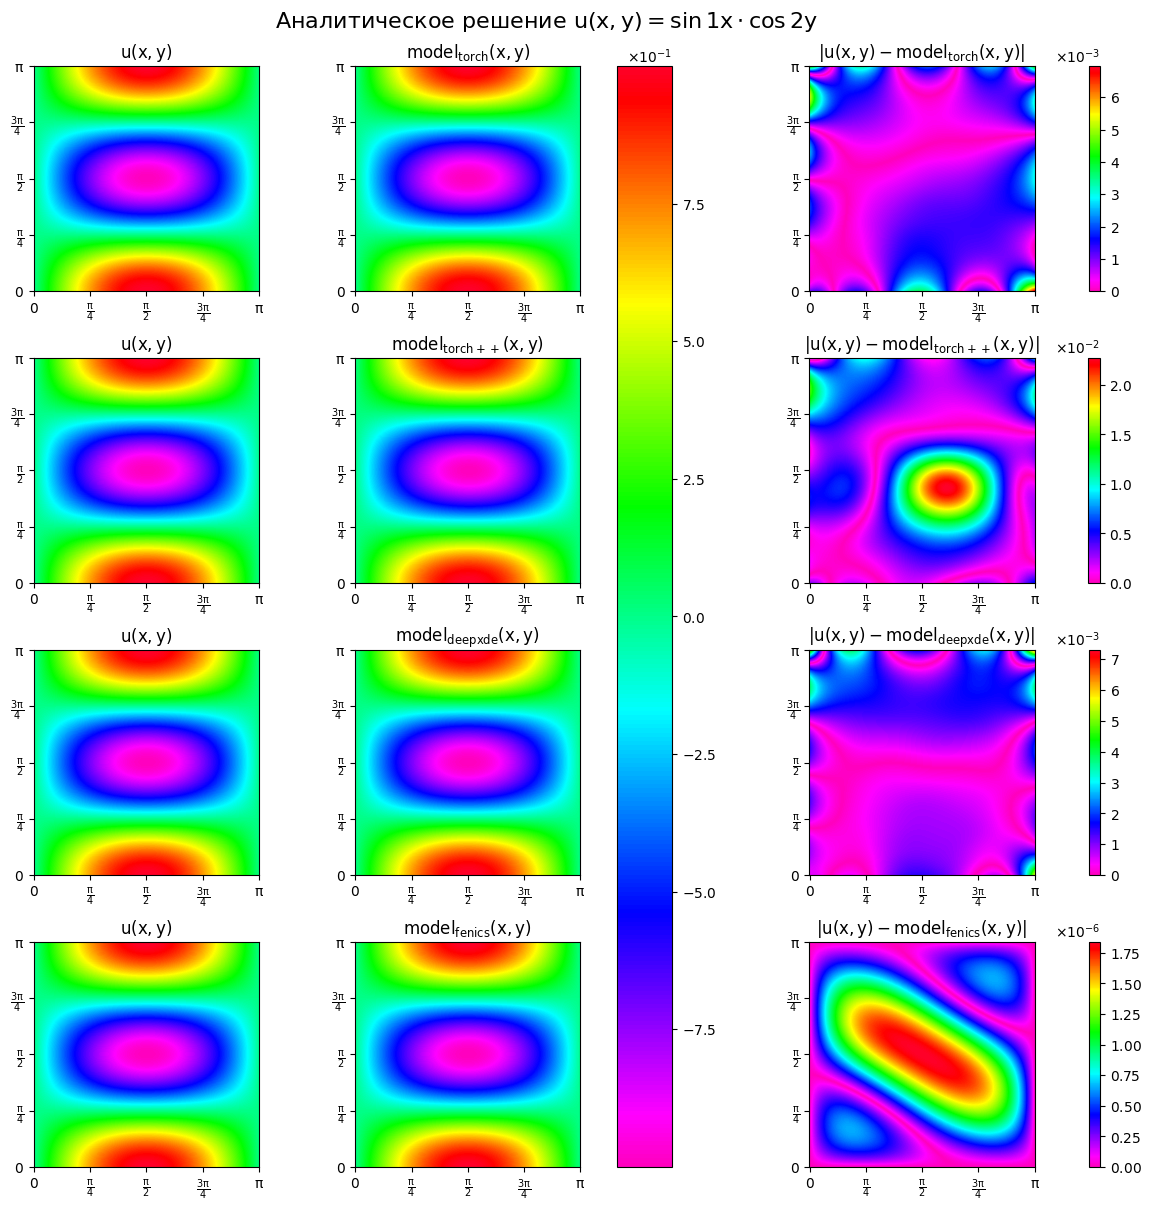

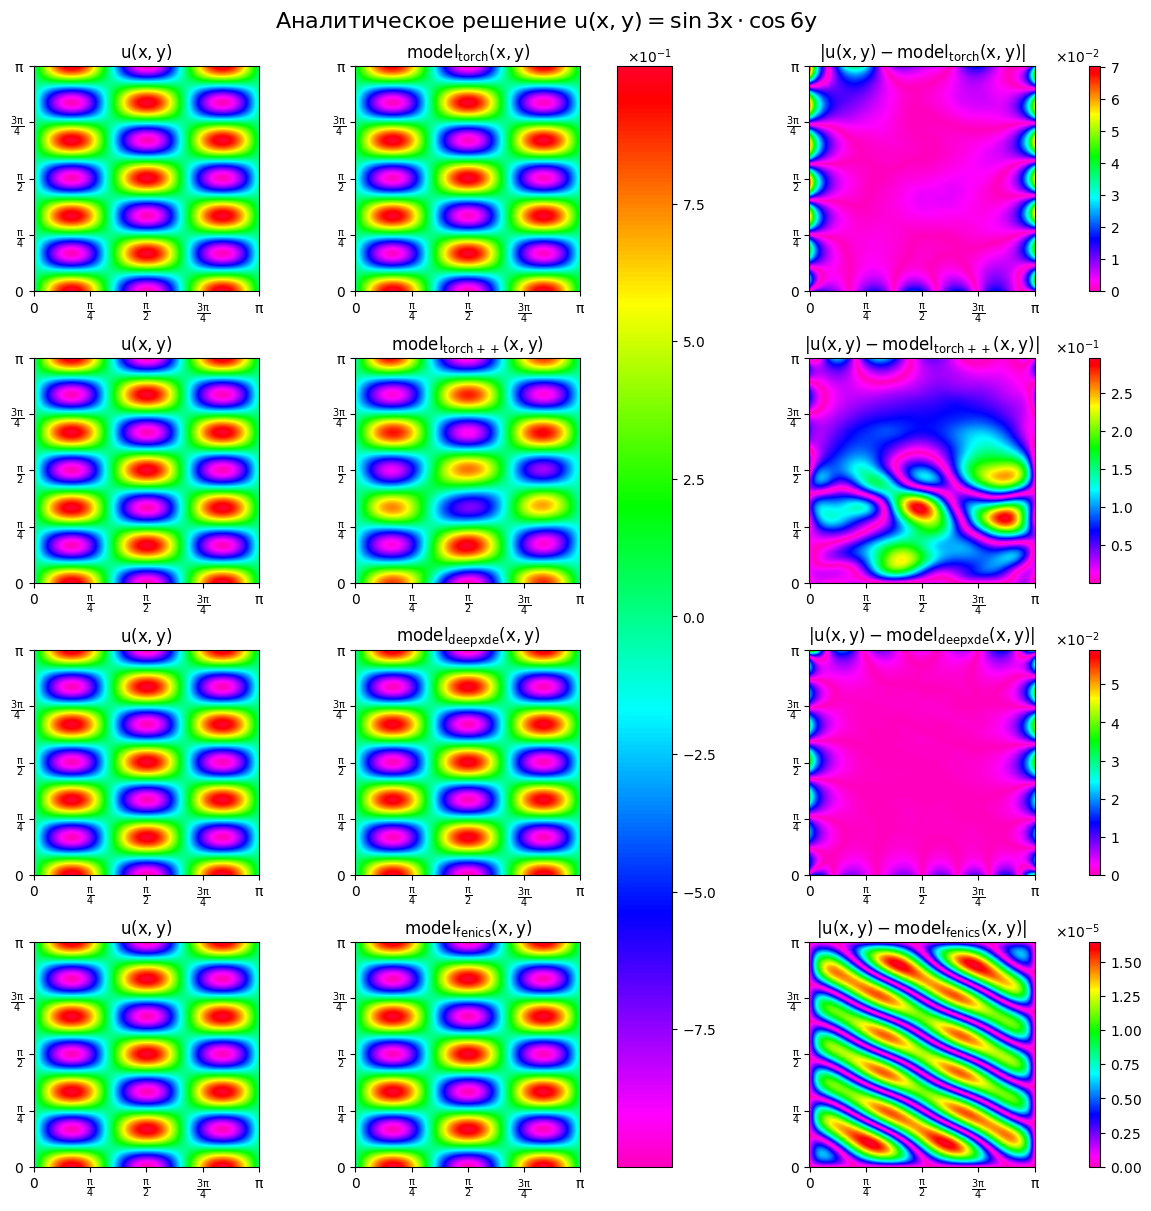

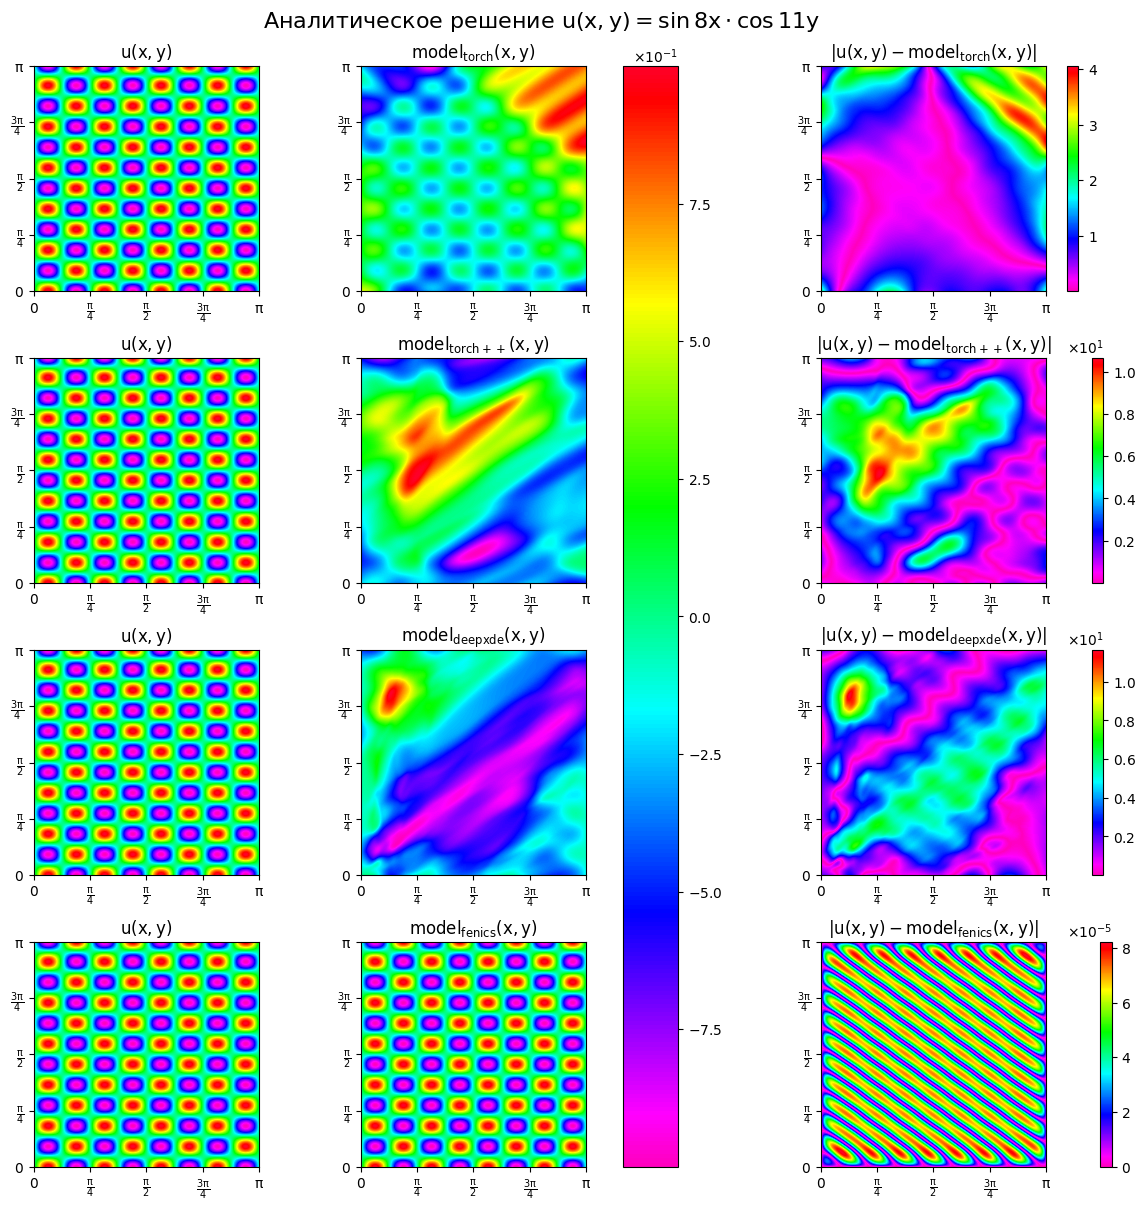

In [29]:
for (a, b) in examples_cfg:
    plot_models(
        results_pytorch[(a,b)],
        results_pytorch_advanced[(a,b)],
        results_dde[(a,b)],
        results[(a,b)],
        1_000
    )